In [67]:
from getdata import GetDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.signal import savgol_filter
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, max_error


In [68]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()

In [69]:
#Interpolacion para que los datos en x1 sean x distantes
x = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),901)
temp = np.zeros((data_orig.shape[0],901))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x,data_orig[i][0][:],data_orig[i][1][:])
    

(0.8736306727949696,
 6.453543968388976,
 -15.193094830961233,
 319.05499145018587)

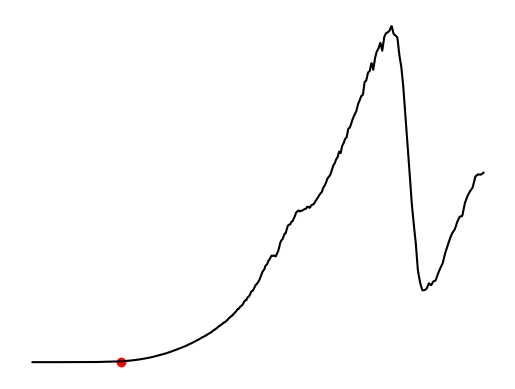

In [70]:
ID = 154
plt.plot(x, temp[ID,:], color='black')
plt.scatter(target[ID],0, color='red')
plt.gca().axis('off')

In [71]:
data = np.zeros((temp.shape[0],temp.shape[1],2))
for i in range(data.shape[0]):
    fil = savgol_filter(temp[i,:], window_length=50, polyorder=2)
    mean = np.mean(fil, axis=0)
    std = np.std(fil, axis=0)
    data[i,:,0] = (fil)/std
    data[i,:,1] = np.gradient(savgol_filter(data[i,:,0], window_length=50, polyorder=2))

In [72]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

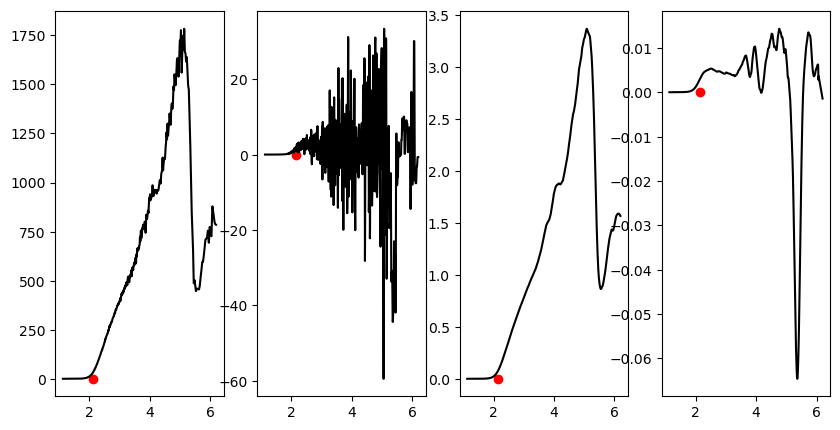

In [73]:
ID = 343
fig, axs = plt.subplots(1,4, figsize=(10,5))

axs[0].plot(x, temp[ID,:], color='black' )
axs[0].scatter(target[ID],0, color='red')

axs[1].plot(x, np.gradient(temp[ID,:]) , color='black')
axs[1].scatter(target[ID],0, color='red')


axs[2].plot(x, data[ID,:,0] , color='black')
axs[2].scatter(target[ID],0, color='red')


axs[3].plot(x, data[ID,:,1], color='black' )
axs[3].scatter(target[ID],0, color='red')





In [74]:
train_input, train_target = data_shuffle[:2472,:,:], target_shuffle[:2472]
val_input, val_target = data_shuffle[2472:2781,:,:], target_shuffle[2472:2781]
test_input, test_target = data_shuffle[2781:,:,:], target_shuffle[2781:]

In [75]:
test_input.shape

(309, 901, 2)

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [77]:
train_input = torch.tensor(train_input, dtype = torch.float, device=device)
train_target = torch.tensor(train_target, dtype = torch.float, device=device)

test_input = torch.tensor(test_input, dtype = torch.float, device=device)
test_target = torch.tensor(test_target, dtype = torch.float, device=device)

val_input = torch.tensor(val_input, dtype = torch.float, device=device)
val_target = torch.tensor(val_target, dtype = torch.float, device=device)

In [78]:
train_input = train_input.permute(0,2,1)
test_input = test_input.permute(0,2,1)
val_input = val_input.permute(0,2,1)


In [79]:
train_input.shape
val_input.shape
test_input.shape

torch.Size([309, 2, 901])

In [89]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm
import math
from torchsummary import summary
from IPython.display import clear_output

class Lineal_Net(nn.Module):
    def __init__(self, criterion, optimizer):
        super(Lineal_Net, self).__init__()

        self.conv1 = nn.Conv1d(2, 16, kernel_size=128, stride=2)
        self.batchnorm1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2)
        self.batchnorm2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2)
        self.batchnorm3 = nn.BatchNorm1d(64)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=2)
        self.batchnorm4 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(64*2, 100)
        self.fc2 = nn.Linear(100,1)

        #self.rnn = nn.RNN(16, hidden_size, num_layers, batch_first=True)

        self.criterion = criterion
        self.optimizer = optimizer


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def train(self, x, y, epochs, lr, batch_size):

        optimizer = self.optimizer(self.parameters(), lr=lr)
        epoch_loss = []
        total_batches = math.floor(y.shape[0]/batch_size)

        for e in range(epochs):
            pbar = tqdm(total= total_batches, desc=f'Epoch {e+1}/{epochs}', position=0, leave=True)
            acc_loss = 0.0
            shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)
            batches = torch.split(shuffle_idx, batch_size)
            
            for batch in batches:

                input_batch = x[batch]
                target_batch = y[batch]

                output = self.forward(input_batch)

                # Calcular la pérdida
                loss = self.criterion(output.float(), target_batch.float())

                # Guardamos la perdida del batchs
                acc_loss += loss.item()
                
                # Realizamos el backpropagation y la actualización de los parámetros
                optimizer.zero_grad()  # Necesario porque pytorch acumula los gradients en lugar de reemplazarlos en cada iteracion
                loss.backward()

                optimizer.step()

                pbar.set_postfix({'Loss': loss.item()})
                pbar.update(1)
                
            epoch_loss.append(acc_loss)
            avg_loss = acc_loss / batch_size
            pbar.set_postfix({'Average Loss': avg_loss})
            pbar.close()
            clear_output(wait=True)
            
        return epoch_loss
    
model = Lineal_Net(nn.L1Loss(), optim.SGD)
model.to(device)
loss = model.train(train_input, train_target, epochs=100, lr=0.001, batch_size=50)

Epoch 100/100: 50it [00:00, 326.70it/s, Average Loss=0.553]                


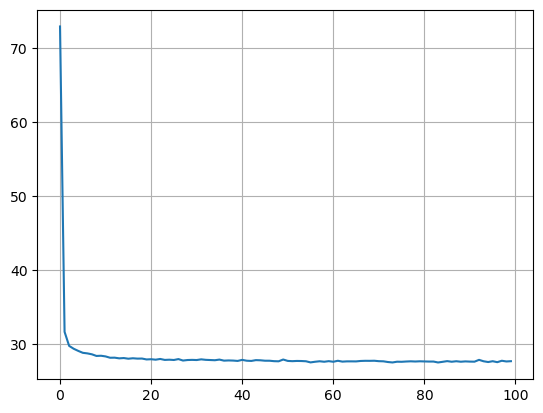

In [90]:
plt.plot(range(100), loss)
plt.grid(True)

In [82]:
val_input[0:1,:,:].shape

torch.Size([1, 2, 901])

In [121]:
y_pred = model.forward(test_input[:,:,:]).to('cpu').detach().numpy()
y = test_target.to('cpu').detach().numpy()

In [122]:
y_pred[0:10]

array([[2.109409 ],
       [2.1541672],
       [2.06703  ],
       [2.0491543],
       [2.061542 ],
       [2.1358812],
       [2.1302807],
       [2.121179 ],
       [1.8696891],
       [2.0503175]], dtype=float32)

In [123]:
val_target[0:10]

tensor([3.3200, 2.0700, 3.3700, 2.8500, 1.9700, 3.1900, 3.2600, 2.5200, 2.2200,
        2.1700], device='cuda:0')

In [124]:
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y)))
print("R2:",r2_score(y_pred=y_pred,y_true=y))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y))

MAE: 0.57076174
MSE: 0.6895155
RMSE: 0.83037066
R2: -0.9873049446074513
Max_Error: 3.3066688


In [103]:
y.shape

(309,)

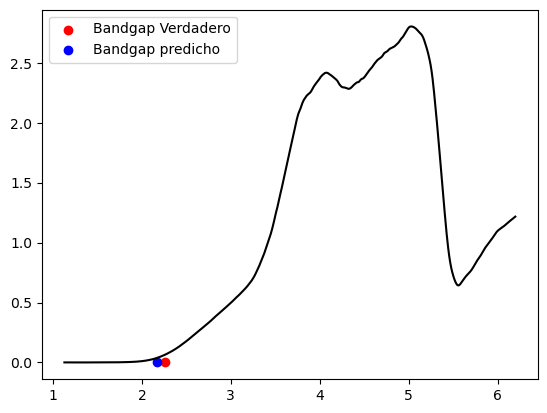

In [126]:
ID =54
#fig, axs = plt.subplots(1, figsize=(10,5))

plt.plot(x, test_input[ID,0,:].cpu(), color='black' )
plt.scatter(y[ID],0, color='red', label='Bandgap Verdadero')
plt.scatter(y_pred[ID],0, color='blue', label='Bandgap predicho')
plt.legend()
plt.show()

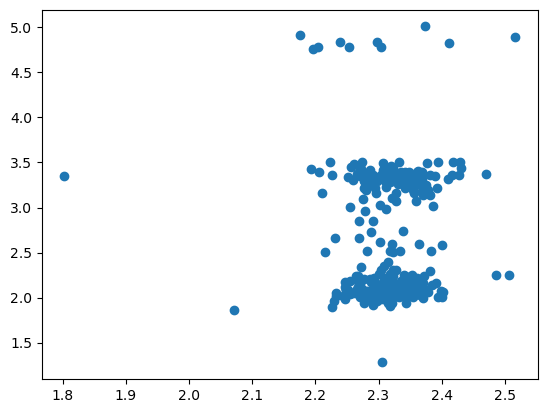

In [110]:
plt.scatter(y_pred,y)